# Decision tree (level 3)

In [21]:
import pandas as pd
from _datetime import date
import pickle
from io import StringIO
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# from transformers import (AutoTokenizer,
#                           AutoModelForMaskedLM)
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.tree import export_text

In [22]:
# df = pd.read_csv('../01trainingdataset/2021-01-11_datasetThirdLevel.csv')
df = pd.read_csv('../../01trainingdataset/dataset/2021-06-06_datasetThirdLevel.csv')
df.head()

,source,condition,CEsnippet,Sentence,reviewedTag,newTag
0,MAYO,Acute kidney failure,Acute kidney failure — also called acute renal...,Acute kidney failure — also called acute renal...,DECLINE FAST FROM 1 DAY TO 1 WEEK,FROM 1 DAY TO 1 WEEK
1,MAYO,Systemic mastocytosis,"Another type, aggressive systemic mastocytosis...","Another type, aggressive systemic mastocytosis...",DECLINE FAST FROM 1 DAY TO 1 WEEK,FROM 1 DAY TO 1 WEEK
2,MAYO,Plague,Pneumonic plague progresses rapidly and may ca...,Pneumonic plague progresses rapidly and may ca...,DECLINE FAST FROM 1 DAY TO 1 WEEK,FROM 1 DAY TO 1 WEEK
3,MAYO,Dermatographia,"Rarely, dermatographia develops more slowly an...","Rarely, dermatographia develops more slowly an...",DECLINE FAST FROM 1 DAY TO 1 WEEK,FROM 1 DAY TO 1 WEEK
4,NHS,Epiglottitis,The symptoms of epiglottitis usually develop q...,The symptoms of epiglottitis usually develop q...,DECLINE FAST FROM 1 DAY TO 1 WEEK,FROM 1 DAY TO 1 WEEK


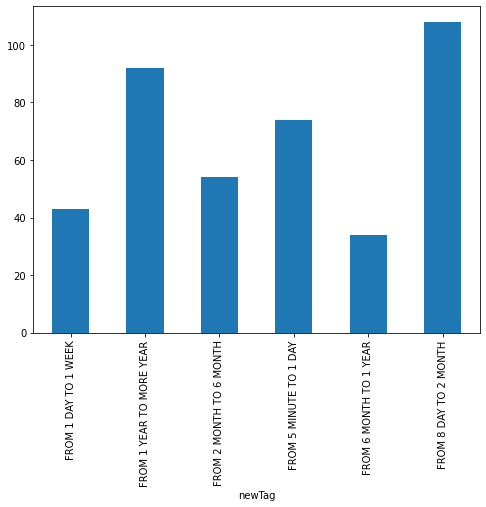

In [23]:
fig = plt.figure(figsize=(8,6))
df.groupby('newTag').Sentence.count().plot.bar(ylim=0)
plt.show()

In [24]:
X = df.Sentence
y = df.newTag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 12,stratify=y)

In [25]:
tr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer(use_idf=True,smooth_idf=True,norm='l2')),
               ('clf', tree.DecisionTreeClassifier(random_state=12)),
              ])
tr.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=12))])

In [27]:
%%time

y_pred = tr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.860655737704918
                          precision    recall  f1-score   support

    FROM 1 DAY TO 1 WEEK       0.93      1.00      0.96        13
FROM 1 YEAR TO MORE YEAR       0.88      0.82      0.85        28
 FROM 2 MONTH TO 6 MONTH       0.71      0.75      0.73        16
  FROM 5 MINUTE TO 1 DAY       1.00      0.91      0.95        22
  FROM 6 MONTH TO 1 YEAR       0.42      0.50      0.45        10
   FROM 8 DAY TO 2 MONTH       0.97      0.97      0.97        33

                accuracy                           0.86       122
               macro avg       0.82      0.83      0.82       122
            weighted avg       0.87      0.86      0.86       122

CPU times: user 14.8 ms, sys: 1.91 ms, total: 16.7 ms
Wall time: 15.5 ms


In [28]:
newdf = pd.DataFrame(X_test)
newdf['testTag'] = y_test.values
newdf['predictedTag'] = y_pred
newdf.rename(columns={'Sentence': 'sentence1'}, inplace=True)

In [29]:
newdf = pd.concat([newdf, df], axis=1)
newdf.dropna(inplace=True)
newdf.head()
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 2 to 402
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sentence1     121 non-null    object
 1   testTag       121 non-null    object
 2   predictedTag  121 non-null    object
 3   source        121 non-null    object
 4   condition     121 non-null    object
 5   CEsnippet     121 non-null    object
 6   Sentence      121 non-null    object
 7   reviewedTag   121 non-null    object
 8   newTag        121 non-null    object
dtypes: object(9)
memory usage: 9.5+ KB


In [30]:
newdf.testTag.value_counts(dropna=False)

FROM 8 DAY TO 2 MONTH       33
FROM 1 YEAR TO MORE YEAR    28
FROM 5 MINUTE TO 1 DAY      22
FROM 2 MONTH TO 6 MONTH     16
FROM 1 DAY TO 1 WEEK        12
FROM 6 MONTH TO 1 YEAR      10
Name: testTag, dtype: int64

In [31]:
newdf.predictedTag.value_counts(dropna=False)

FROM 8 DAY TO 2 MONTH       33
FROM 1 YEAR TO MORE YEAR    26
FROM 5 MINUTE TO 1 DAY      20
FROM 2 MONTH TO 6 MONTH     17
FROM 1 DAY TO 1 WEEK        13
FROM 6 MONTH TO 1 YEAR      12
Name: predictedTag, dtype: int64

In [32]:
newdf.to_csv('04Level3/'+str(date.today())+'_DT_testingDataResult.csv')

In [33]:
newdf['flag'] = (newdf['testTag'] == newdf['predictedTag'])
flag = [False]
errors = newdf[newdf.flag.isin(flag)]
#errors.head(39)

# Saving the model

In [34]:
#Save the model
filename = 'models/'+str(date.today())+'_Level3_DecisionTree.pkl'
pickle.dump(tr, open(filename, 'wb'))
# Close the pickle instances
#pickle.close()

# Plotting results

In [ ]:
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Logistic Regression')
plt.xlabel('DMV_Test_1')
plt.ylabel('DMV_Test_2')
plt.legend()
plt.show()